In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Multi-Factor Models

## Implementing the CAPM in Python

### How to do it...

1. Import the libraries:

In [87]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pandas_datareader.data as web
import pandas_datareader as pdr

2. Specify the risky asset and the time horizon:

In [88]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = 'SPY'
RISK_FREE = '^IRX'
START_DATE = '2016-01-01'
END_DATE = '2020-10-01'

3. Download data from yfinance:

In [89]:
# !pip install yfinance

In [90]:
import yfinance as yf
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK, RISK_FREE], start=START_DATE, end=END_DATE, adjusted=True, progress=False)

4. Resample to monthly data and calculate simple returns:

In [91]:
df.head()

Adj Close                          Close                     \
                  AMZN         SPY   ^IRX        AMZN         SPY   ^IRX   
Date                                                                       
2015-12-31  675.890015  185.890274  0.148  675.890015  203.869995  0.148   
2016-01-04  636.989990  183.291626  0.155  636.989990  201.020004  0.155   
2016-01-05  633.789978  183.601654  0.205  633.789978  201.360001  0.205   
2016-01-06  632.650024  181.285645  0.205  632.650024  198.820007  0.205   
2016-01-07  607.940002  176.936371  0.190  607.940002  194.050003  0.190   

                  High                            Low                     \
                  AMZN         SPY   ^IRX        AMZN         SPY   ^IRX   
Date                                                                       
2015-12-31  687.750000  205.889999  0.165  675.890015  203.869995  0.135   
2016-01-04  657.719971  201.029999  0.170  627.510010  198.589996  0.153   
2016-01-05  646.909973  201.899994  0.205  627.650024  200.050003  0.205   
2016-01-06  639.789978  200.059998  0.205  620.309998  197.600006  0.198   
2016-01-07  630.000000  197.440002  0.195  605.210022  193.589996  0.185   

                  Open                      Volume                  
                  AMZN         SPY   ^IRX     AMZN        SPY ^IRX  
Date                                                                
2015-12-31  686.080017  205.130005  0.140  3749600  114877900  0.0  
2016-01-04  656.289978  200.490005  0.165  9314500  222353500  0.0  
2016-01-05  646.859985  201.399994  0.205  5822600  110845800  0.0  
2016-01-06  622.000000  198.339996  0.205  5329200  152112600  0.0  
2016-01-07  621.799988  195.330002  0.190  7074900  213436100  0.0

In [92]:
my_data = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', MARKET_BENCHMARK: 'market', RISK_FREE: 'rf'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
my_data.head()

,asset,market,rf
Date,,,
2016-01-31,-0.131516,-0.049786,1.027027
2016-02-29,-0.058739,-0.000826,0.026667
2016-03-31,0.074423,0.067266,-0.373377
2016-04-30,0.111094,0.003941,0.000000
2016-05-31,0.095817,0.017012,0.466321


In [93]:
my_data['rf'] = my_data['rf'] / 100

In [94]:
my_data.head()

,asset,market,rf
Date,,,
2016-01-31,-0.131516,-0.049786,0.010270
2016-02-29,-0.058739,-0.000826,0.000267
2016-03-31,0.074423,0.067266,-0.003734
2016-04-30,0.111094,0.003941,0.000000
2016-05-31,0.095817,0.017012,0.004663


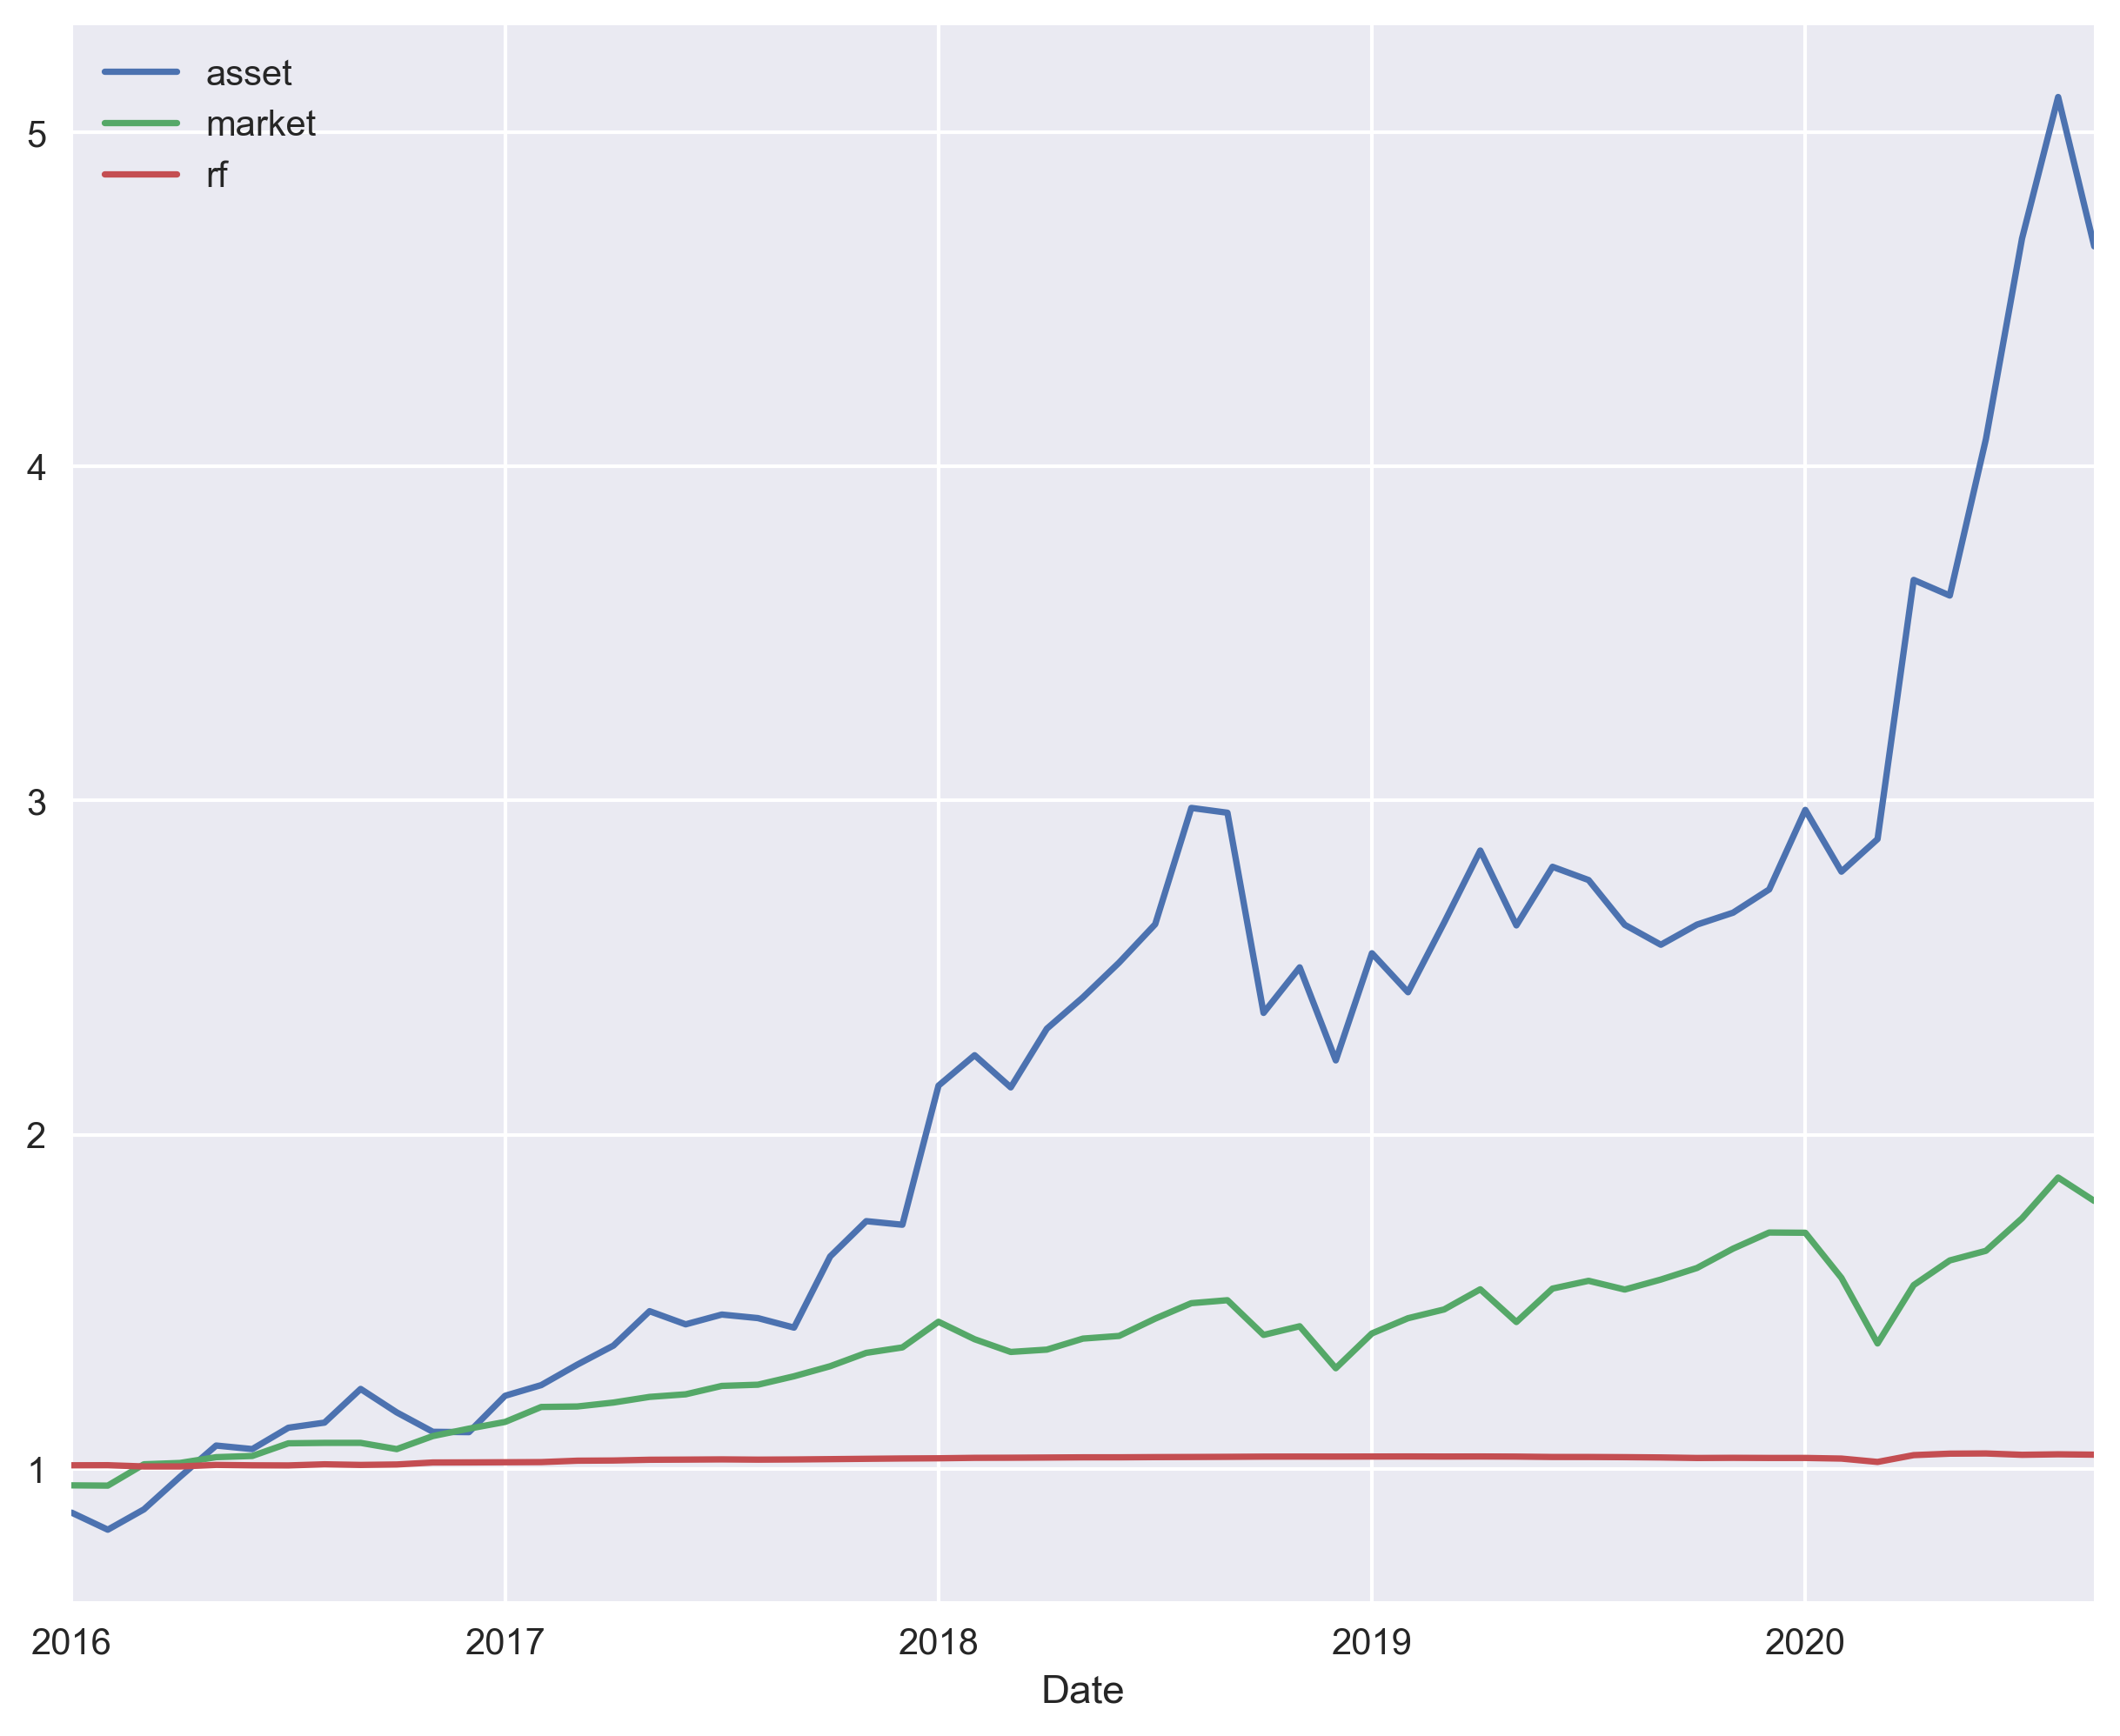

In [95]:
(my_data + 1).cumprod().plot()

5. Calculate beta using the covariance approach: 

In [96]:
my_data.cov()

,asset,market,rf
asset,0.007132,0.002349,0.000048
market,0.002349,0.001813,0.000056
rf,0.000048,0.000056,0.000013


In [97]:
my_data.cov().iloc[0,1]

0.002349198708232852

In [98]:
my_data.market.var() * 12

0.02176126183934697

In [99]:
my_data.asset.var() * 12

0.085581563043039

In [100]:
covariance = my_data.cov().iloc[0,1]
benchmark_variance = my_data.market.var()
beta = covariance / benchmark_variance
beta

1.2954388723829713

6. Prepare the input and estimate CAPM as a linear regression:

In [101]:
my_data.head()

,asset,market,rf
Date,,,
2016-01-31,-0.131516,-0.049786,0.010270
2016-02-29,-0.058739,-0.000826,0.000267
2016-03-31,0.074423,0.067266,-0.003734
2016-04-30,0.111094,0.003941,0.000000
2016-05-31,0.095817,0.017012,0.004663


In [102]:
y = my_data.pop('asset')

In [103]:
rf = my_data.pop('rf')

In [104]:
X = my_data

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     40.94
Date:                Thu, 26 Nov 2020   Prob (F-statistic):           3.63e-08
Time:                        10:54:07   Log-Likelihood:                 76.363
No. Observations:                  57   AIC:                            -148.7
Df Residuals:                      55   BIC:                            -144.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.009      1.827      0.0

### There's more...

#### Risk-free rate (13 Week Treasury Bill)

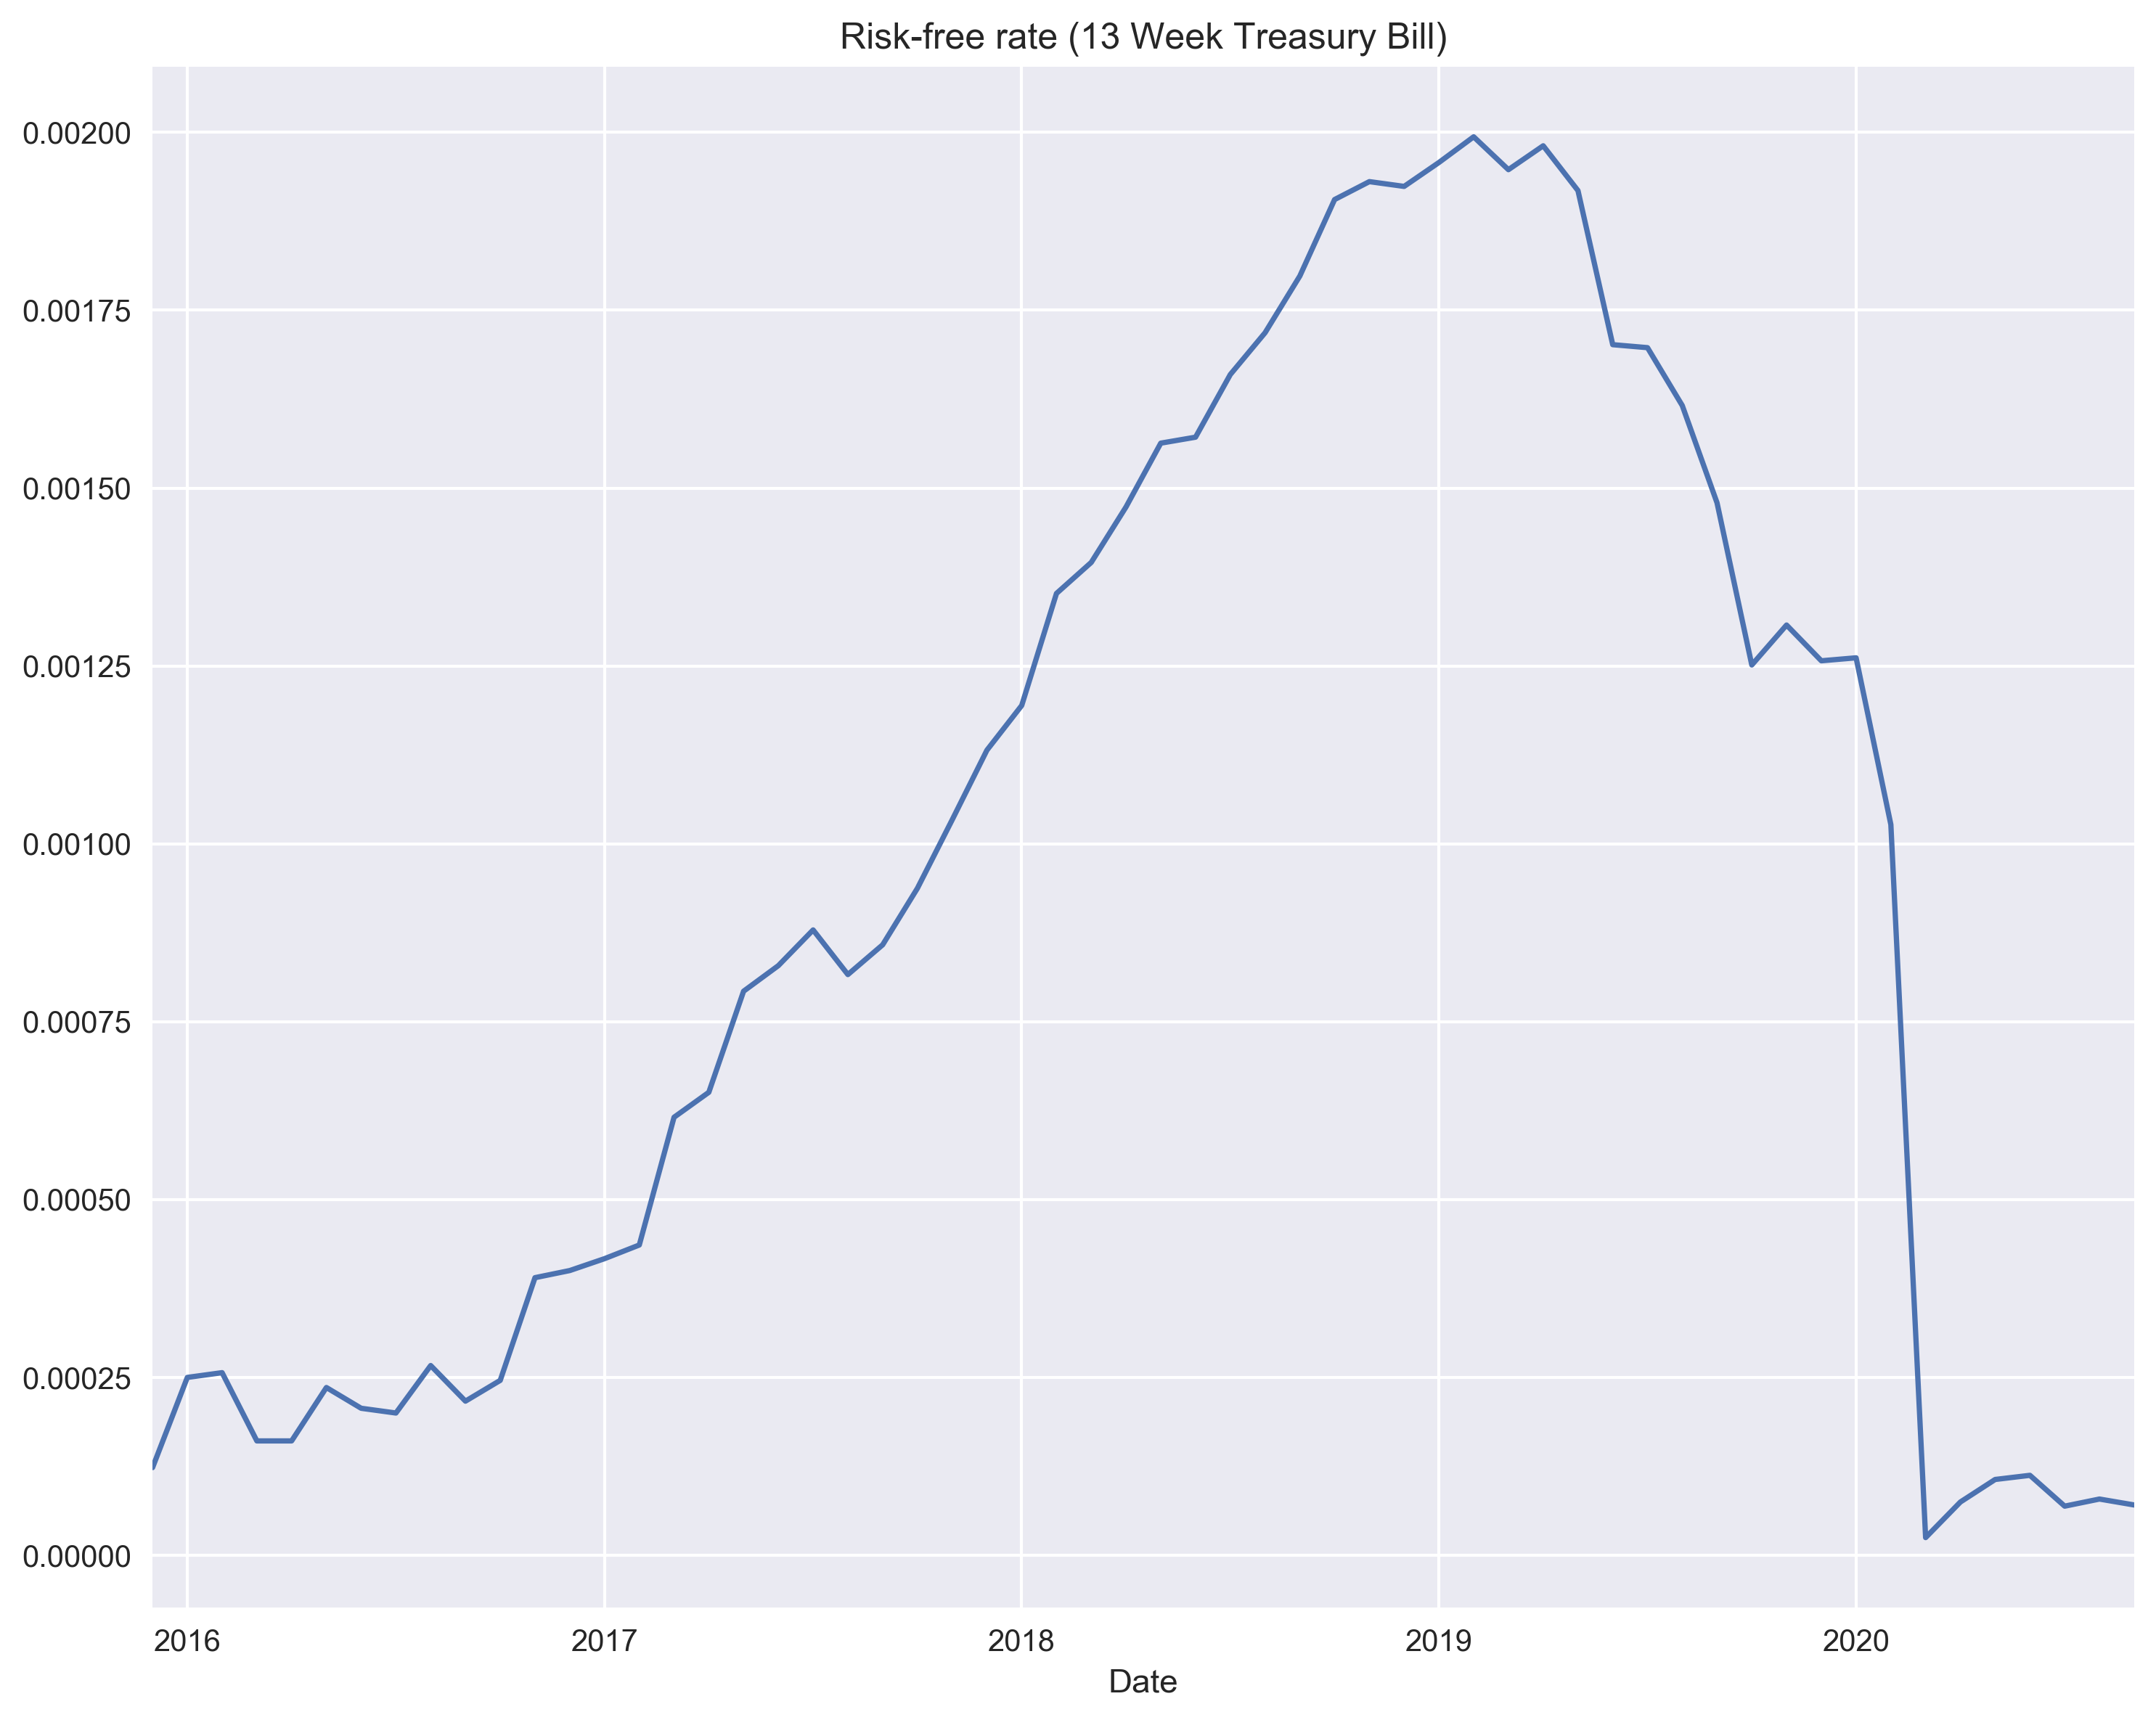

In [105]:
# period lenght in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download('^IRX',
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample('M').last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im2.png')
plt.show()

#### Risk-free rate (3-Month Treasury Bill)

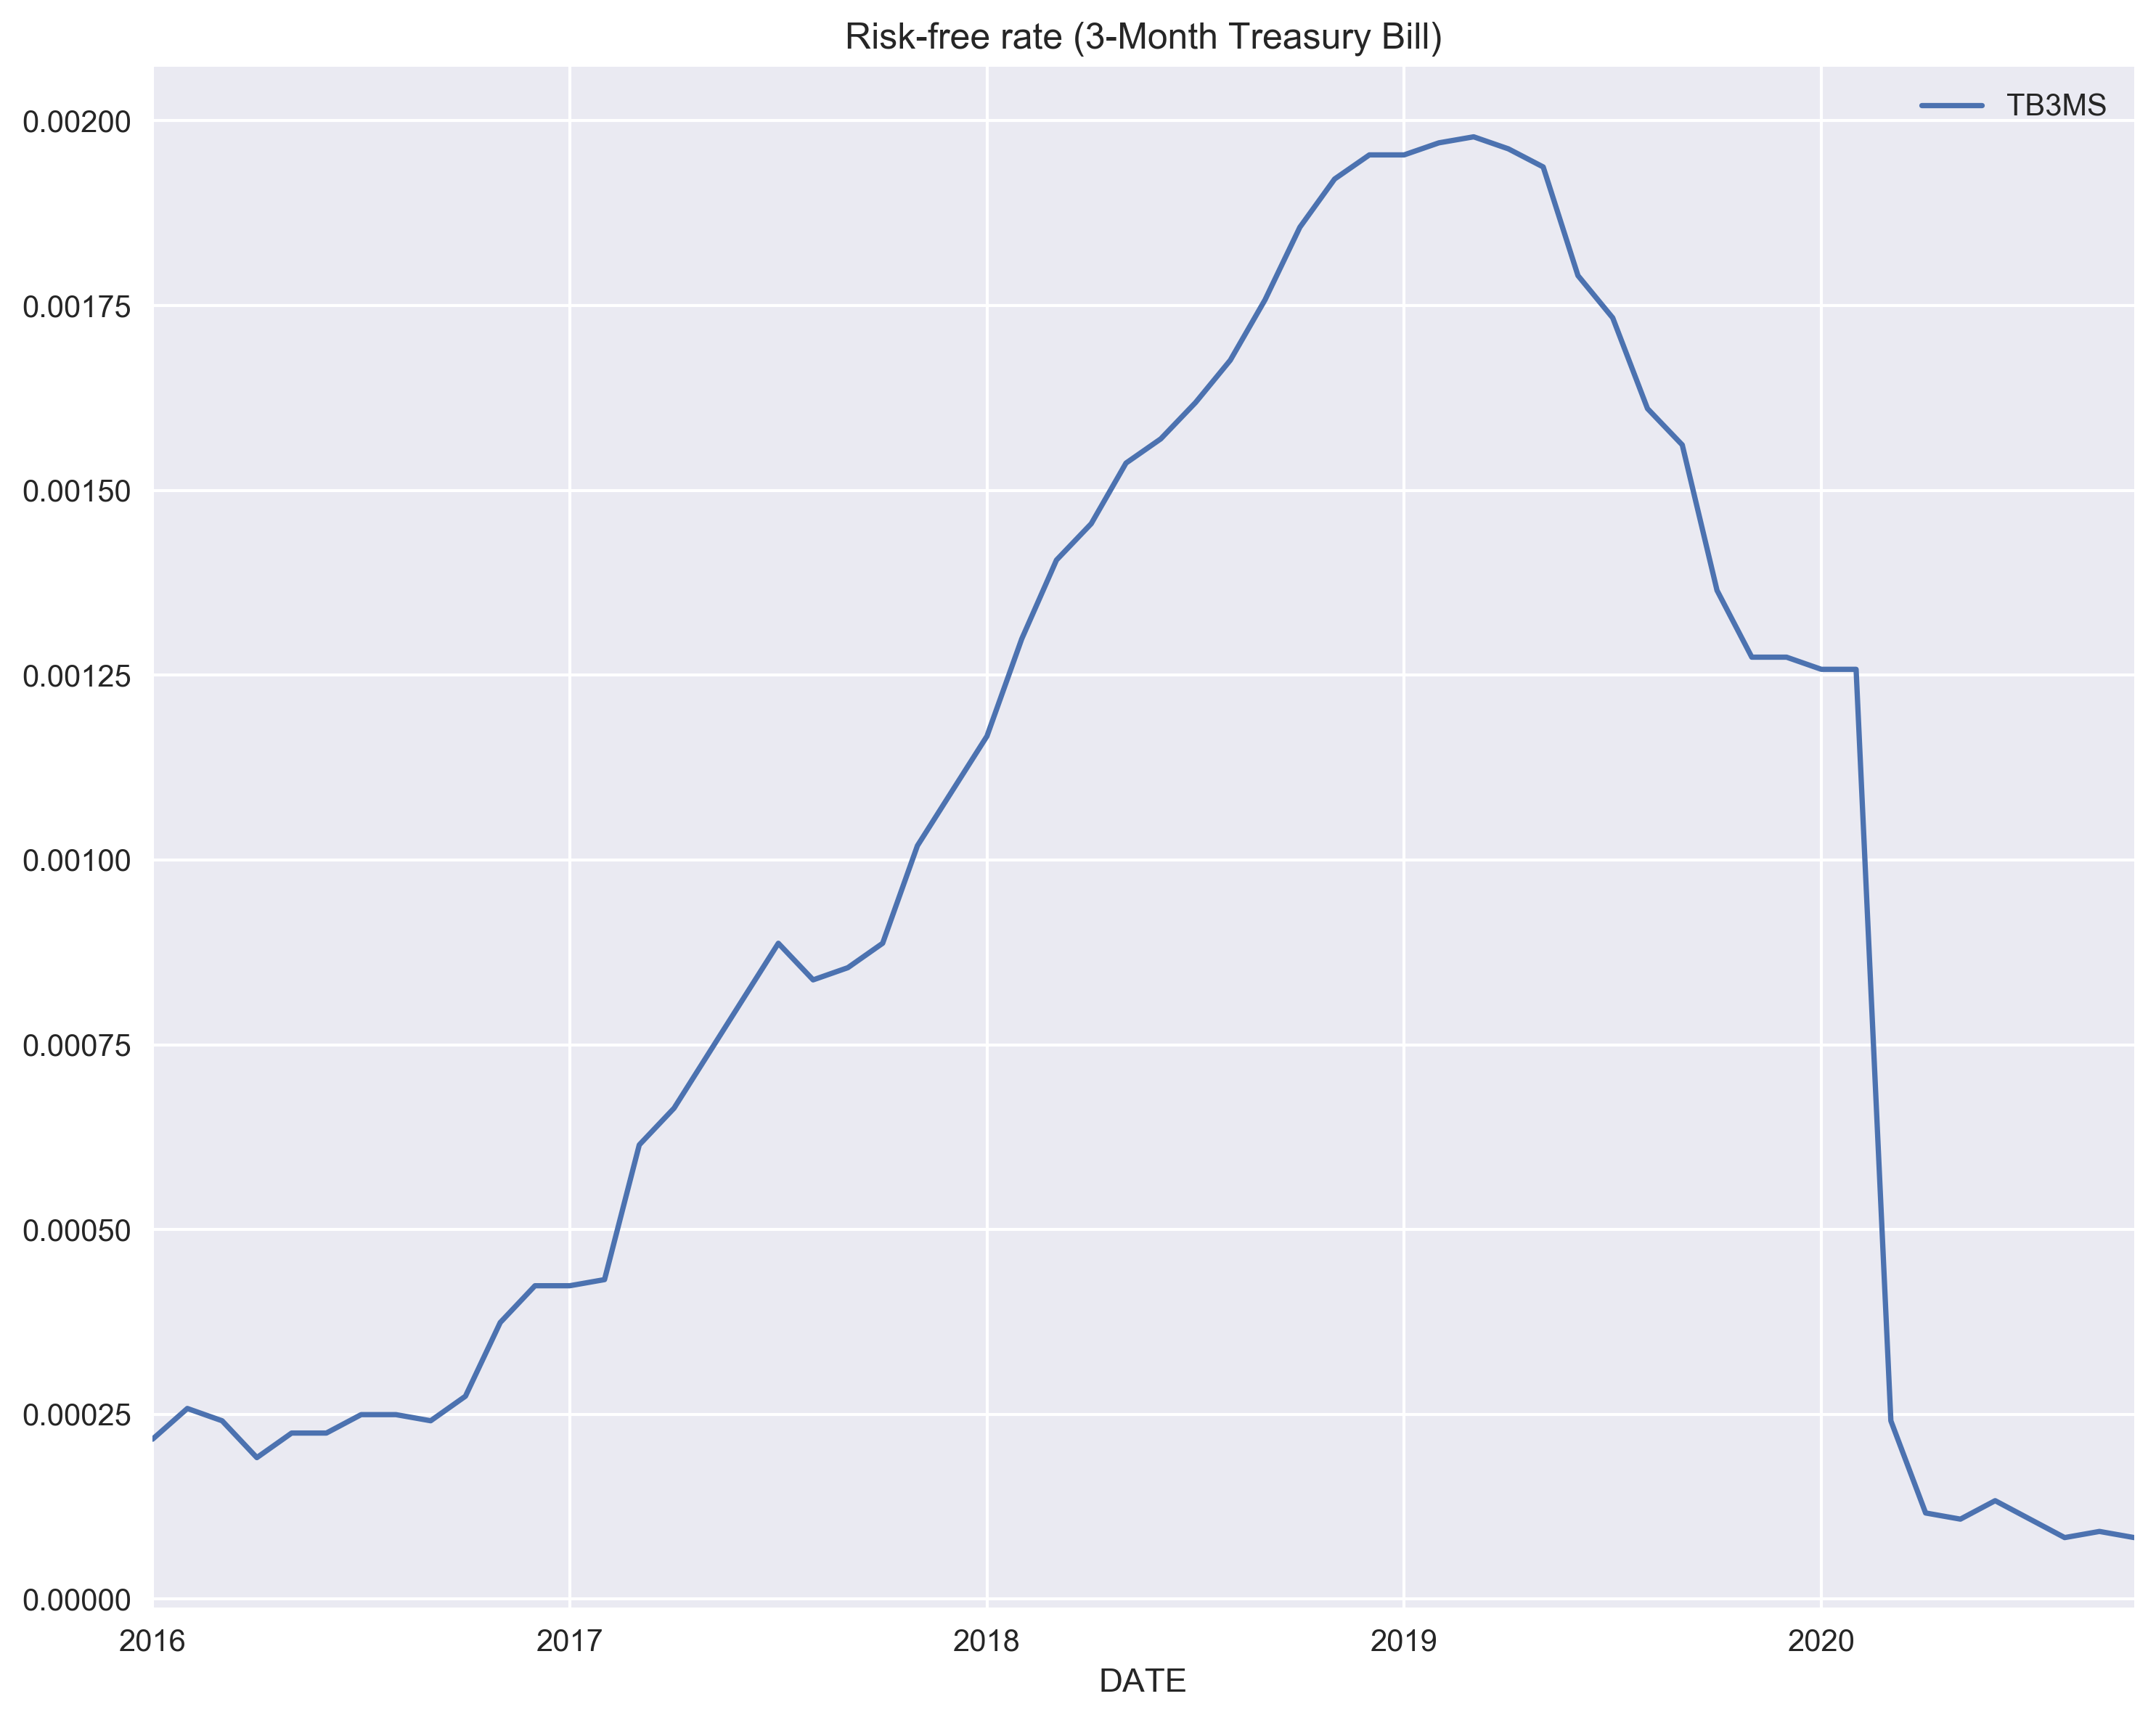

In [106]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im3.png')
plt.show()

## Implementing the Fama-French three-factor model in Python

### How to do it...

1. Import the libraries:

In [107]:
import statsmodels.formula.api as smf

2. Download data from prof. French's website:

## download and unzip the file from Prof. French's website
http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip


3. Define parameters:

In [108]:
RISKY_ASSET = 'FB'
START_DATE = '2013-12-31'
END_DATE = '2020-10-01'

4. Load data from the source CSV file and keep only the monthly data:

In [109]:
# load data from csv
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)


In [110]:
factor_df.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [111]:
# load data from csv
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

In [112]:
factor_df.shape

(1121, 5)

5. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [113]:
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

In [114]:
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-3.32,0.85,-2.09,0.00
2014-02,4.65,0.34,-0.40,0.00
2014-03,0.43,-1.89,5.09,0.00
2014-04,-0.19,-4.24,1.14,0.00
2014-05,2.06,-1.86,-0.27,0.00


In [115]:
factor_df.iloc[0, 2]

'   -2.09'

In [116]:
factor_df.dtypes

mkt    object
smb    object
hml    object
rf     object
dtype: object

6. Convert the values to numeric and divide by 100:

In [117]:
factor_df = factor_df.apply(pd.to_numeric, errors='coerce') \
                     .div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0
2014-02,0.0465,0.0034,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0509,0.0
2014-04,-0.0019,-0.0424,0.0114,0.0
2014-05,0.0206,-0.0186,-0.0027,0.0


In [118]:
factor_df.iloc[0, 2]

-0.0209

7. Download the prices of the risky asset:

In [119]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1701 rows of data.


8. Calculate monthly returns on the risky asset:

In [120]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

Date
2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

9. Merge the datasets and calculate excess returns:

In [121]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf
ff_data.head()

,mkt,smb,hml,rf,rtn,excess_rtn
date,,,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0,0.144922,0.144922
2014-02,0.0465,0.0034,-0.0040,0.0,0.094135,0.094135
2014-03,0.0043,-0.0189,0.0509,0.0,-0.120070,-0.120070
2014-04,-0.0019,-0.0424,0.0114,0.0,-0.007636,-0.007636
2014-05,0.0206,-0.0186,-0.0027,0.0,0.058883,0.058883


10. Estimate the three-factor model:

In [122]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                   data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     7.445
Date:                Thu, 26 Nov 2020   Prob (F-statistic):           0.000224
Time:                        10:54:27   Log-Likelihood:                 97.978
No. Observations:                  71   AIC:                            -188.0
Df Residuals:                      67   BIC:                            -178.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0095      0.008      1.213      0.2

### There's more...

1. Import the libraries:

In [123]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

2. Print available datasets (here only first 5):

In [124]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

3. Download the selected dataset:

In [125]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

In [126]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

4. Inspect the description of the dataset

In [127]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202010 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French

  0 : (82 rows x 4 cols)
  1 : Annual Factors: January-December (6 rows x 4 cols)


5. View the monthly dataset:

In [128]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.87,-2.02,0.0
2014-02,4.65,0.31,-0.37,0.0
2014-03,0.43,-1.85,4.91,0.0
2014-04,-0.19,-4.21,1.11,0.0
2014-05,2.06,-1.91,-0.12,0.0


## Implementing the rolling three-factor model on a portfolio of assets

### How to do it...

1. Import the libraries:

In [129]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define the parameters:

In [130]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

3. Download the factor related data:

In [131]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor

,Mkt-RF,SMB,HML,RF
Date,,,,
2009-12,2.75,6.12,-0.11,0.01
2010-01,-3.36,0.37,0.29,0.00
2010-02,3.40,1.19,3.18,0.00
2010-03,6.31,1.43,2.16,0.01
2010-04,2.00,4.86,2.93,0.01
...,...,...,...,...
2020-06,2.46,2.70,-2.22,0.01
2020-07,5.77,-2.18,-1.31,0.01
2020-08,7.63,-0.26,-2.95,0.01


In [132]:
df_three_factor = df_three_factor.div(100)
df_three_factor

,Mkt-RF,SMB,HML,RF
Date,,,,
2009-12,0.0275,0.0612,-0.0011,0.0001
2010-01,-0.0336,0.0037,0.0029,0.0000
2010-02,0.0340,0.0119,0.0318,0.0000
2010-03,0.0631,0.0143,0.0216,0.0001
2010-04,0.0200,0.0486,0.0293,0.0001
...,...,...,...,...
2020-06,0.0246,0.0270,-0.0222,0.0001
2020-07,0.0577,-0.0218,-0.0131,0.0001
2020-08,0.0763,-0.0026,-0.0295,0.0001


In [133]:
df_three_factor.index = df_three_factor.index.format()

In [134]:
df_three_factor

,Mkt-RF,SMB,HML,RF
2009-12,0.0275,0.0612,-0.0011,0.0001
2010-01,-0.0336,0.0037,0.0029,0.0000
2010-02,0.0340,0.0119,0.0318,0.0000
2010-03,0.0631,0.0143,0.0216,0.0001
2010-04,0.0200,0.0486,0.0293,0.0001
...,...,...,...,...
2020-06,0.0246,0.0270,-0.0222,0.0001
2020-07,0.0577,-0.0218,-0.0131,0.0001
2020-08,0.0763,-0.0026,-0.0295,0.0001
2020-09,-0.0363,0.0006,-0.0256,0.0001


4. Download the prices of risky assets from Yahoo Finance:

In [135]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2265 rows of data.


In [136]:
asset_df.head()

Adj Close                                        Close              \
                AAPL        AMZN        GOOG       MSFT      AAPL        AMZN   
Date                                                                            
2009-12-30  6.467456  136.490005  310.202271  24.113148  7.558571  136.490005   
2009-12-31  6.439648  134.520004  308.832428  23.739305  7.526072  134.520004   
2010-01-04  6.539882  133.899994  312.204773  24.105360  7.643214  133.899994   
2010-01-05  6.551187  134.690002  310.829926  24.113148  7.656428  134.690002   
2010-01-06  6.446983  132.250000  302.994293  23.965164  7.534643  132.250000   

                                       High              ...         Low  \
                  GOOG       MSFT      AAPL        AMZN  ...        GOOG   
Date                                                     ...               
2009-12-30  310.202271  30.959999  7.571429  138.399994  ...  307.851105   
2009-12-31  308.832428  30.480000  7.619643  137.279999  ...  308.832428   
2010-01-04  312.204773  30.950001  7.660714  136.610001  ...  310.954468   
2010-01-05  310.829926  30.959999  7.699643  135.479996  ...  309.609497   
2010-01-06  302.994293  30.770000  7.686786  134.729996  ...  302.047852   

                           Open                                        Volume  \
                 MSFT      AAPL        AMZN        GOOG       MSFT       AAPL   
Date                                                                            
2009-12-30  30.799999  7.458214  138.399994  308.095184  31.150000  412084400   
2009-12-31  30.480000  7.611786  137.089996  311.208527  30.980000  352410800   
2010-01-04  30.590000  7.622500  136.250000  312.304413  30.620001  493729600   
2010-01-05  30.639999  7.664286  133.429993  312.418976  30.850000  601904800   
2010-01-06  30.520000  7.656428  134.600006  311.761444  30.879999  552160000   

                                        
               AMZN     GOOG      MSFT  
Date                                    
2009-12-30  6913200  2942100  42006200  
2009-12-31  4523000  2448700  31929700  
2010-01-04  7599900  3927000  38409100  
2010-01-05  8851900  6031900  49749600  
2010-01-06  7178800  7987100  58182400  

[5 rows x 24 columns]

5. Calculate the monthly returns on the risky assets:

In [137]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

In [138]:
asset_df[ASSETS]

,AMZN,GOOG,AAPL,MSFT
Date,,,,
2010-01,-0.067722,-0.145231,-0.088597,-0.075459
2010-02,-0.055897,-0.005925,0.065396,0.022146
2010-03,0.146706,0.076538,0.148471,0.021625
2010-04,0.009796,-0.073036,0.111022,0.042677
2010-05,-0.084902,-0.076222,-0.016125,-0.151394
...,...,...,...,...
2018-08,0.132365,0.000764,0.200422,0.062993
2018-09,-0.004824,-0.020292,-0.008303,0.018161
2018-10,-0.202192,-0.097782,-0.030478,-0.066101


6. Calculate the portfolio returns:

In [54]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)

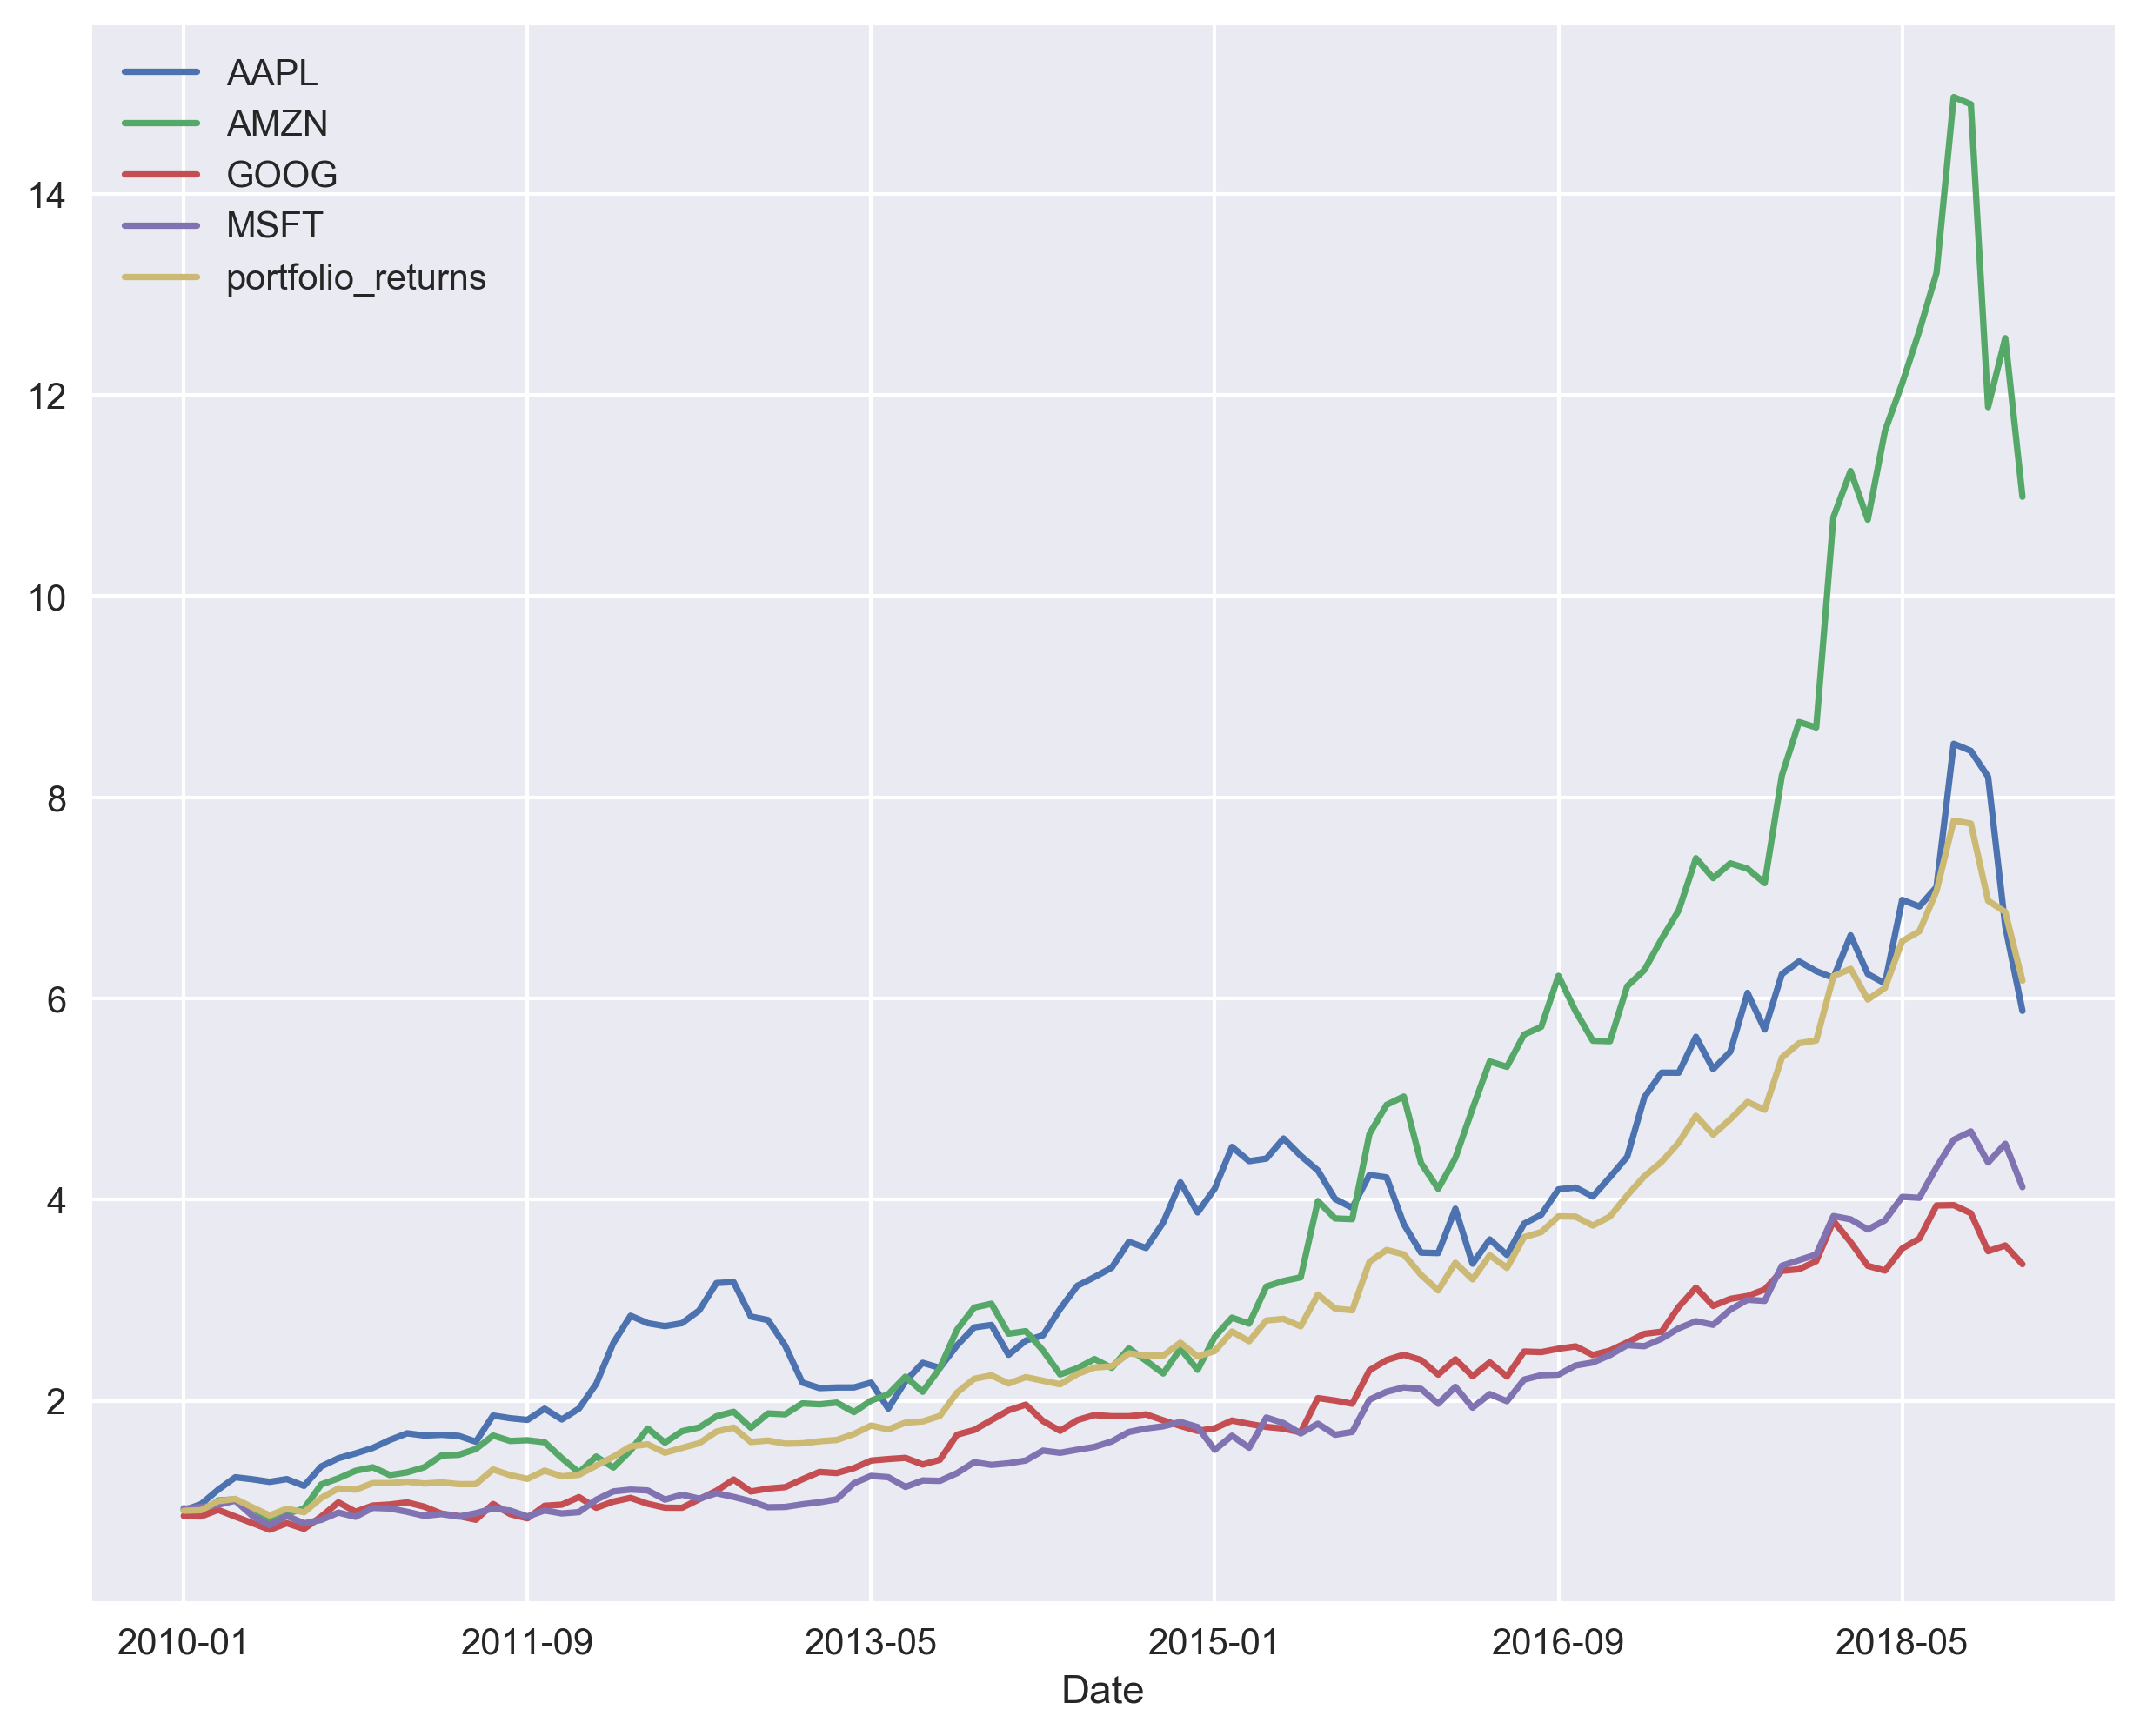

In [55]:
(asset_df + 1).cumprod().plot()

7. Merge the datasets:

In [56]:
print(asset_df.shape)
asset_df.head()

(108, 5)


,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088597,-0.067722,-0.145231,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148471,0.146706,0.076538,0.021625,0.098335
2010-04,0.111022,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151394,-0.082161


In [57]:
print(df_three_factor.shape)
df_three_factor.head()

(131, 4)


,Mkt-RF,SMB,HML,RF
2009-12,0.0275,0.0612,-0.0011,0.0001
2010-01,-0.0336,0.0037,0.0029,0.0000
2010-02,0.0340,0.0119,0.0318,0.0000
2010-03,0.0631,0.0143,0.0216,0.0001
2010-04,0.0200,0.0486,0.0293,0.0001


In [58]:
ff_data.head()

,mkt,smb,hml,rf,rtn,excess_rtn
date,,,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0,0.144922,0.144922
2014-02,0.0465,0.0034,-0.0040,0.0,0.094135,0.094135
2014-03,0.0043,-0.0189,0.0509,0.0,-0.120070,-0.120070
2014-04,-0.0019,-0.0424,0.0114,0.0,-0.007636,-0.007636
2014-05,0.0206,-0.0186,-0.0027,0.0,0.058883,0.058883


In [59]:
ASSETS

['AMZN', 'GOOG', 'AAPL', 'MSFT']

In [60]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [61]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2010-01,-0.094252,-0.0336,0.0037,0.0029,0.0000,-0.094252
2010-02,0.006430,0.0340,0.0119,0.0318,0.0000,0.006430
2010-03,0.098335,0.0631,0.0143,0.0216,0.0001,0.098235
2010-04,0.022615,0.0200,0.0486,0.0293,0.0001,0.022515
2010-05,-0.082161,-0.0789,0.0015,-0.0240,0.0001,-0.082261


8. Define a function for the rolling n-factor model

In [62]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

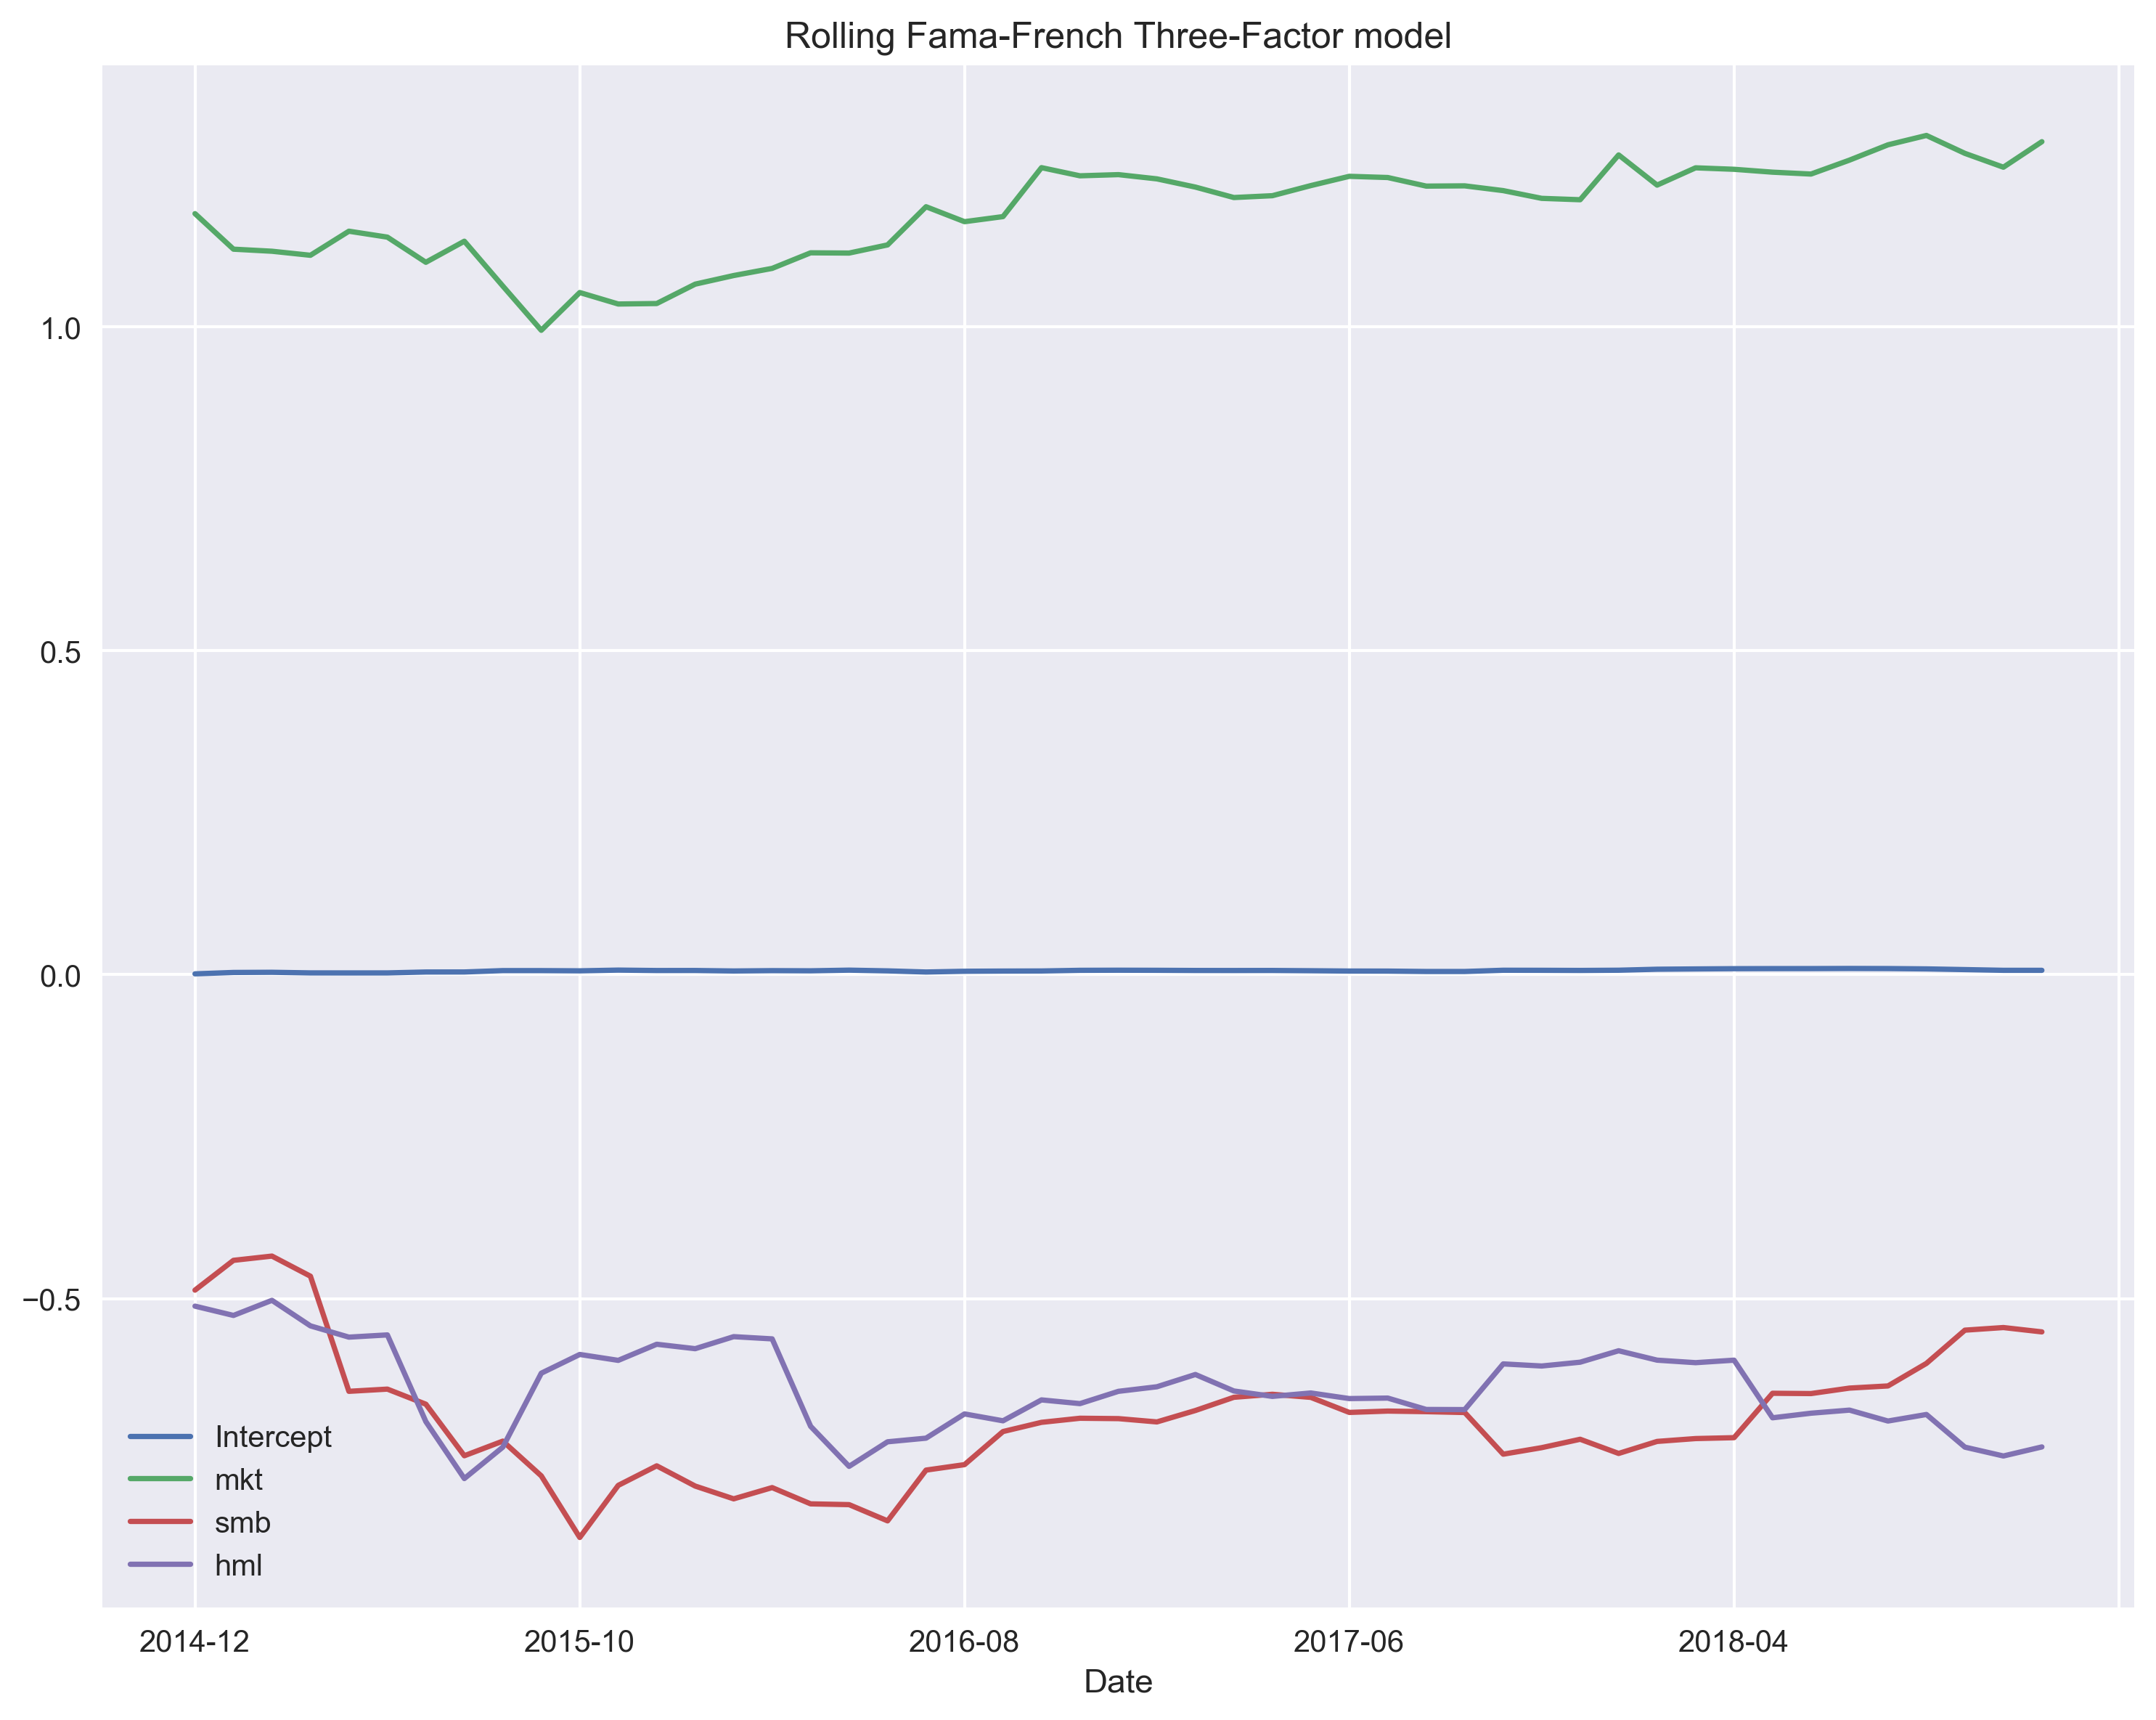

In [63]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()

## Implementing the four- and five-factor models in Python

### How to do it...

1. Import the libraries:

In [64]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Specify the risky asset and the time horizon:

In [65]:
RISKY_ASSET = 'AMZN'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

3. Download the risk factors from prof. French's website:

In [66]:
# three factors 
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor.index = df_three_factor.index.format()

# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()

4. Download the data of the risky asset from Yahoo Finance:

In [67]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


5. Calculate monthly returns:

In [68]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'

6. Merge the datasets for the four-factor models:

In [69]:
# join all datasets on the index
four_factor_data = df_three_factor.join(df_mom).join(y)

# rename columns
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# divide everything (except returns) by 100
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
# four_factor_data.index = pd.to_datetime(four_factor_data.index, format='%Y-%m')
four_factor_data.index = pd.to_datetime(pd.Series(four_factor_data.index).apply(str).values)

# select period of interest
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01,-0.0332,0.0087,-0.0202,0.0,0.0174,-0.100554,-0.100554
2014-02-01,0.0465,0.0031,-0.0037,0.0,0.0205,0.009507,0.009507
2014-03-01,0.0043,-0.0185,0.0491,0.0,-0.0338,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0421,0.0111,0.0,-0.0377,-0.095847,-0.095847
2014-05-01,0.0206,-0.0191,-0.0012,0.0,0.0121,0.027685,0.027685


In [70]:
type(four_factor_data.index[0]), type(str(four_factor_data.index[0]))

(pandas._libs.tslibs.timestamps.Timestamp, str)

7. Merge the datasets for the five-factor models:

In [71]:
# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
# five_factor_data.index = pd.to_datetime(five_factor_data.index, format='%Y-%m')
five_factor_data.index = pd.to_datetime(pd.Series(five_factor_data.index).apply(str).values)

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01-01,-0.0332,0.0058,-0.0202,-0.0393,-0.0136,0.0,-0.100554,-0.100554
2014-02-01,0.0465,0.0011,-0.0037,-0.0024,-0.0041,0.0,0.009507,0.009507
2014-03-01,0.0043,-0.0113,0.0491,0.0217,0.0183,0.0,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0413,0.0111,0.0353,0.0102,0.0,-0.095847,-0.095847
2014-05-01,0.0206,-0.0191,-0.0012,0.0003,-0.0105,0.0,0.027685,0.027685


8. Estimate the four-factor model:

In [72]:
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                            data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     16.66
Date:                Thu, 26 Nov 2020   Prob (F-statistic):           5.32e-09
Time:                        10:52:10   Log-Likelihood:                 86.133
No. Observations:                  60   AIC:                            -162.3
Df Residuals:                      55   BIC:                            -151.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0093      0.008      1.151      0.2

9. Estimate the five-factor model:

In [73]:
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     15.51
Date:                Thu, 26 Nov 2020   Prob (F-statistic):           1.93e-09
Time:                        10:52:10   Log-Likelihood:                 89.030
No. Observations:                  60   AIC:                            -166.1
Df Residuals:                      54   BIC:                            -153.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.008      1.282      0.2

In [74]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

In [75]:
ff_dict

{0:          Mkt-RF   SMB   HML    RF
 Date                             
 2014-01   -3.32  0.87 -2.02  0.00
 2014-02    4.65  0.31 -0.37  0.00
 2014-03    0.43 -1.85  4.91  0.00
 2014-04   -0.19 -4.21  1.11  0.00
 2014-05    2.06 -1.91 -0.12  0.00
 ...         ...   ...   ...   ...
 2020-06    2.46  2.70 -2.22  0.01
 2020-07    5.77 -2.18 -1.31  0.01
 2020-08    7.63 -0.26 -2.95  0.01
 2020-09   -3.63  0.06 -2.56  0.01
 2020-10   -2.10  4.44  3.88  0.01
 
 [82 rows x 4 columns],
 1:       Mkt-RF   SMB    HML    RF
 Date                           
 2014   11.71 -7.95  -1.54  0.02
 2015    0.08 -3.92  -9.73  0.02
 2016   13.30  6.59  22.42  0.20
 2017   21.51 -4.90 -13.70  0.80
 2018   -6.93 -3.35  -9.22  1.81
 2019   28.28 -6.32 -10.88  2.14,
 'DESCR': 'F-F Research Data Factors\n-------------------------\n\nThis file was created by CMPT_ME_BEME_RETS using the 202010 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French\n\n  0 : (

In [139]:
np.matmul??